## Overview

In [1]:
# Imports
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
# Read data into dataframe
df = pd.read_parquet("escooter_history.parquet")

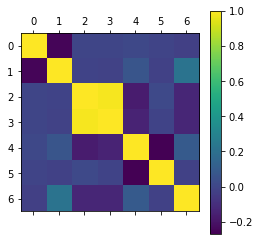

In [3]:
# Short overview over features
df.corr()
plt.matshow(df.corr())
plt.colorbar()

## Closer look into datetime column

In [4]:
# Group dataframe by datetime to get an overview
df[["datetime","temp"]].groupby("datetime").count().sort_values("temp",ascending=False).head(20)

# Result: The exact datetime appears max 5 times

,temp
datetime,
2020-12-11 08:34:25,5
2020-10-23 17:02:20,5
2020-11-28 17:15:44,5
2019-08-16 17:50:49,5
2020-04-24 18:17:21,5
2020-07-02 17:25:38,5
2020-10-16 18:42:17,5
2020-10-03 17:24:31,5
2019-07-10 16:42:32,5


In [5]:
# Add new columns so deeper insights can be provided 

df["time"]=df["datetime"].dt.time
df["month_year"]=df["datetime"].dt.to_period("M")
df["date"]=df["datetime"].dt.date
df["year"]=pd.DatetimeIndex(df['datetime']).year
df['month'] = pd.DatetimeIndex(df['datetime']).month
df["month_w"]=df["datetime"].dt.month_name()
df['quarter'] = df['datetime'].dt.to_period('Q')

## Closer look into holiday and working day 

In [6]:
# How many rentals were on workingdays and how many on non-workingdays? 
df_workingday=df[["workingday","temp"]].groupby("workingday",as_index=False).count()
df_workingday=df_workingday.rename(columns={"temp":"count_rents"})
df_workingday

,workingday,count_rents
0,0,1016982
1,1,2279039


In [7]:
# How many days where holidays, workingdays or neither?
# Absolute values

pd.crosstab(df["workingday"],df["holiday"],margins=True)
# Result: Many days are neither one 

holiday,0,1,All
workingday,,,
0,927708,89274,1016982
1,2279039,0,2279039
All,3206747,89274,3296021


In [8]:
# How many days where holidays, workingdays or neither?
# Relative values

pd.crosstab(df["workingday"],df["holiday"],normalize="all",margins=True)

holiday,0,1,All
workingday,,,
0,0.281463,0.027085,0.308548
1,0.691452,0.000000,0.691452
All,0.972915,0.027085,1.000000


## Absolute development of rentals per month

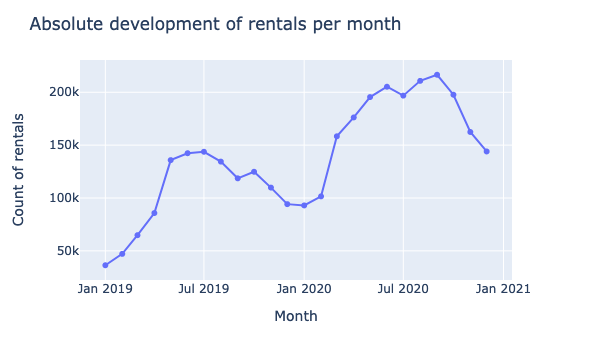

In [32]:
# Count rentals per month/year-combination
df_month_year=df.groupby("month_year",as_index=False).count().sort_values(by="month_year")

# Cast period column to string column
df_month_year["month_year"]=df_month_year["month_year"].astype("str")

# Show rentals per month 
fig_counts_mj_cust = px.line(df_month_year, x="month_year", y="windspeed", markers=True)
fig_counts_mj_cust.update_layout(title="Absolute development of rentals per month", xaxis_title="Month", yaxis_title="Count of rentals")

## Absolute development of rentals per quarter

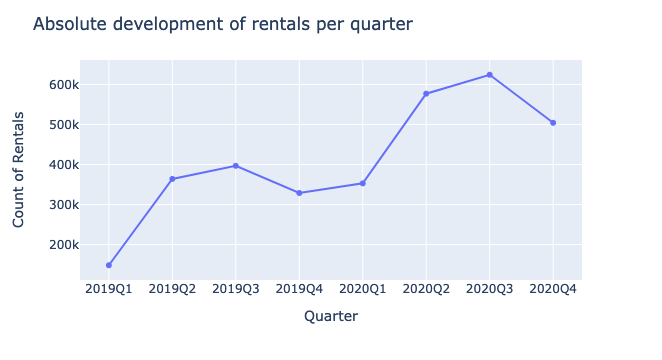

In [10]:
# Count rentals per quarter
df_quarter = df.groupby("quarter",as_index=False).count().sort_values(by="quarter")
df_quarter["quarter"]=df_quarter.quarter.astype(str)

# Show amount of rentals per quarter
fig_counts_per_quarter = px.line(df_quarter, x="quarter", y="registered_customer", markers=True)
fig_counts_per_quarter.update_layout( title="Absolute development of rentals per quarter", xaxis_title="Quarter", yaxis_title="Count of Rentals")

## Absolute development of rentals per month and per customer group (registered vs non-registered customers)

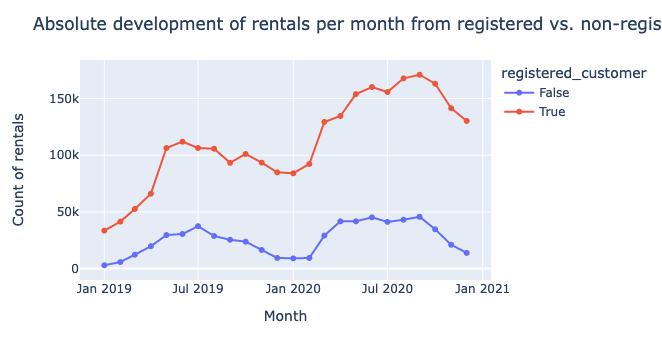

In [11]:
# Count rentals per month/year-combination and type of customer
df_month_year=df.groupby(["month_year","registered_customer"],as_index=False).count().sort_values(by="month_year")

# Cast period column to string column
df_month_year["month_year"]=df_month_year["month_year"].astype("str")

# Show rentals of registered vs non-registered customers per month 
fig_counts_mj_cust = px.line(df_month_year, x="month_year", y="windspeed", color="registered_customer", markers=True)
fig_counts_mj_cust.update_layout(title="Absolute development of rentals per month from registered vs. non-registered customers", xaxis_title="Month", yaxis_title="Count of rentals")

## Absolute development of rentals per quarter and per customer group (registered vs non-registered customers)

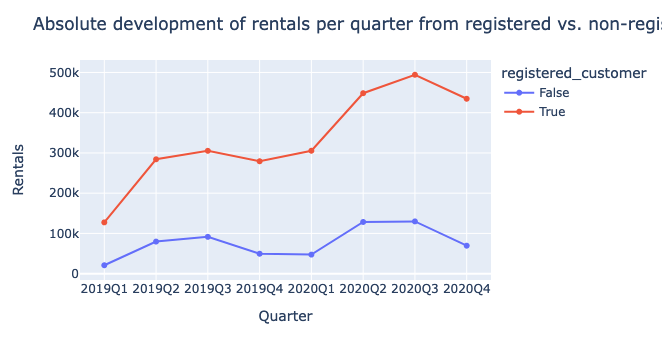

In [12]:
# Change quarter column to period object
df['quarter'] = df['datetime'].dt.to_period('Q')

# Count rentals per quarter and per type of customer
df_quarter = df.groupby(["quarter","registered_customer"],as_index=False).count().sort_values(by="quarter")

# Cast quarter column as string
df_quarter["quarter"]=df_quarter.quarter.astype(str)

# Show rentals per quarter and per type of customer
fig_rents_per_quarter_pc = px.line(df_quarter, x="quarter", y="windspeed", color="registered_customer", markers=True)
fig_rents_per_quarter_pc.update_layout(title="Absolute development of rentals per quarter from registered vs. non-registered customers", xaxis_title="Quarter", yaxis_title="Rentals")

## Relative development of rentals per month and per customer group (registered vs non-registered customers)

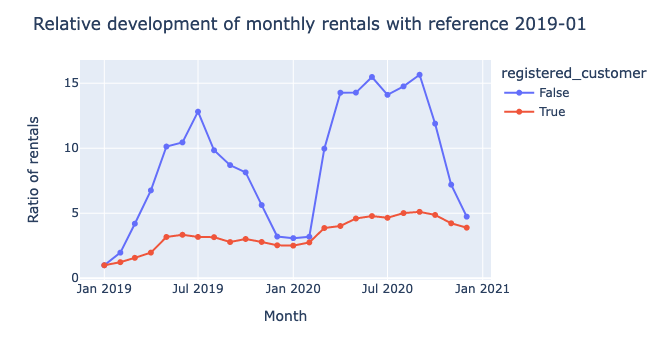

In [13]:
# Drop columns and save it in new dataframe
df_first_count = df_month_year[["month_year","registered_customer","datetime"]]

# Show only rentals in January 2019 (earliest date in data set)
df_first_count = df_first_count[df_first_count["month_year"]=="2019-01"]

# Rename columns to avoid confusion
df_first_count = df_first_count.rename(columns={"month_year":"begin","datetime":"count_begin"})

# Merge new dataframe with dataframe which shows the amount of rentals per month/year combination and type of customer
# Join on type of customer
df_merged = pd.merge(df_month_year, df_first_count, how="inner", on=["registered_customer"])[["month_year","registered_customer","datetime","count_begin"]]

# Calculate the ratio between:
# the amount of rentals from registered customers vs. non-registered customers per month 
# and the amount of rentals from registered customers vs. non-registered customers in 2019-01
df_merged["ratio"] = df_merged.datetime / df_merged.count_begin

# Show the percentual change of rentals from all months in comparison to earliest date
# Graph shows when the highest percentual change had happened 
fig_dev_per_month=px.line(df_merged, x="month_year", y="ratio", color="registered_customer", markers=True)
fig_dev_per_month.update_layout( title="Relative development of monthly rentals with reference 2019-01", xaxis_title="Month", yaxis_title="Ratio of rentals")

## Relative normalized development of rentals per quarter and per customer group (registered vs non-registered customers)

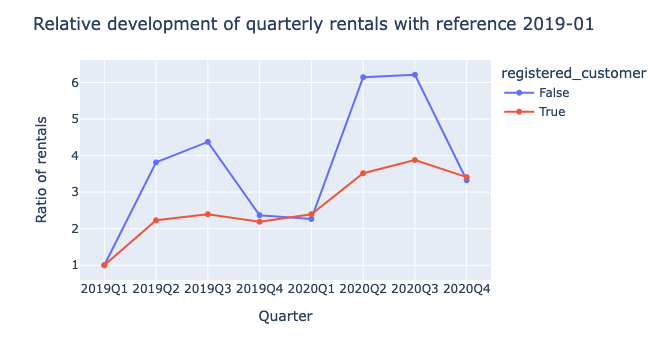

In [14]:
# Drop columns and save it in a new dataframe
df_first_count_q = df_quarter[["quarter","registered_customer","datetime"]]

# Show only rentals in 2019Q1 (earliest date in data set)
df_first_count_q = df_first_count_q[df_first_count_q["quarter"]=="2019Q1"]

df_first_count_q = df_first_count_q.rename(columns={"quarter":"begin","datetime":"count_begin"})

# Merge new dataframe with dataframe which shows the amount of rentals per quarter from registered vs non-registered customers
df_merged_q = pd.merge(df_quarter, df_first_count_q, how="inner", on="registered_customer")[["quarter","registered_customer","datetime","begin","count_begin"]]

# Calculate ratio between amount of rentals per group in every quarter to amount of rentals in 2019Q1
df_merged_q["ratio"]=df_merged_q.datetime / df_merged_q.count_begin

# Show when the highest percentual change had happened
fig_dev_per_quarter = px.line(df_merged_q, x="quarter", y="ratio", color="registered_customer", markers=True)
fig_dev_per_quarter.update_layout( title="Relative development of quarterly rentals with reference 2019-01", xaxis_title="Quarter", yaxis_title="Ratio of rentals")

In [16]:
df_2019 = df[df["year"]==2019]
df_2019
df_2020 = df[df["year"]==2020]

## Relative development of rentals per month 

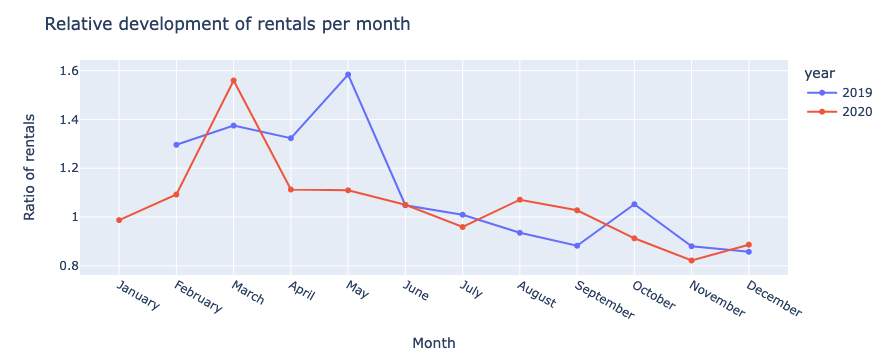

In [17]:
# Calculate amount of rentals per year 2019 and month
df_2019_gmw = df_2019[["month","month_w","year","datetime"]].groupby(["year","month_w","month"],as_index=False).count()
df_2019_gmw = df_2019_gmw.rename(columns={"datetime":"count"}).sort_values(by="month")

# Calculate amount of rentals per year 2020 and month
df_2020_gmw = df_2020[["month","month_w","year","datetime"]].groupby(["year","month_w","month"],as_index=False).count()
df_2020_gmw = df_2020_gmw.rename(columns={"datetime":"count"}).sort_values(by="month")

# Append two dataframes and safe in one 
df_gmw_append = df_2019_gmw.append(df_2020_gmw)

# Save amount of rentals from last month in the next row
df_gmw_append["last_month_count"]=df_gmw_append["count"].shift()

# Save year of last row in the next row
df_gmw_append["year_last_count"]=df_gmw_append["year"].shift()

# When the years in the same row don't match --> NaN in column "last_month_count"
# Is optional as ratio between Dec 19 and Jan 20 could also be important
# df_gmw_append.loc[df_gmw_append.year_last_count != df_gmw_append.year, "last_month_count"]= None

# Calculate ratio between rentals from two following months
df_gmw_append["ratio"]=df_gmw_append["count"] / df_gmw_append.last_month_count

# Show monthly development of amount of rentals
fig_gmw = px.line(df_gmw_append,x="month_w",y="ratio",color="year",markers=True)
fig_gmw.update_layout(title="Relative development of rentals per month", xaxis_title="Month", yaxis_title="Ratio of rentals")

## Relative development of rentals per quarter

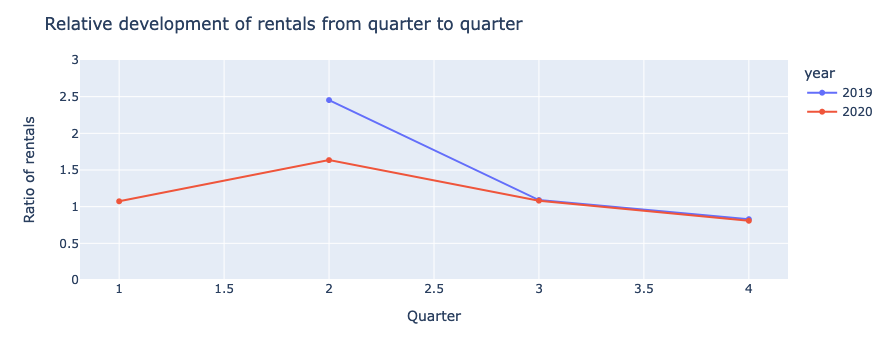

In [18]:
# Wie bekomme ich es hin, dass auf der x-Achse statt 1 Q1 etc steht ? 

df['quarter'] = df['datetime'].dt.quarter

# Count number of rentals per year and quarter
df_quarter_g = df.groupby(["year","quarter"],as_index=False).count()
df_quarter_g = df_quarter_g[["year","quarter","datetime"]].rename(columns={"datetime":"count_rentals"})

# Save quarter from row in following row
df_quarter_g["last_quarter"]=df_quarter_g.count_rentals.shift()

# Calculate ratio between two following quarters
df_quarter_g["ratio"] = df_quarter_g.count_rentals / df_quarter_g.last_quarter

# Show percentual change of rentals from quarter to quarter
fig_quarterly_dev = px.line(df_quarter_g,x="quarter",y="ratio",color="year", markers=True)
fig_quarterly_dev.update_layout(title="Relative development of rentals from quarter to quarter",yaxis_range=[0,3], xaxis_title="Quarter", yaxis_title="Ratio of rentals")


## Relative development between same quarters (ratio between 2020Q1 to 2019Q1 etc.)

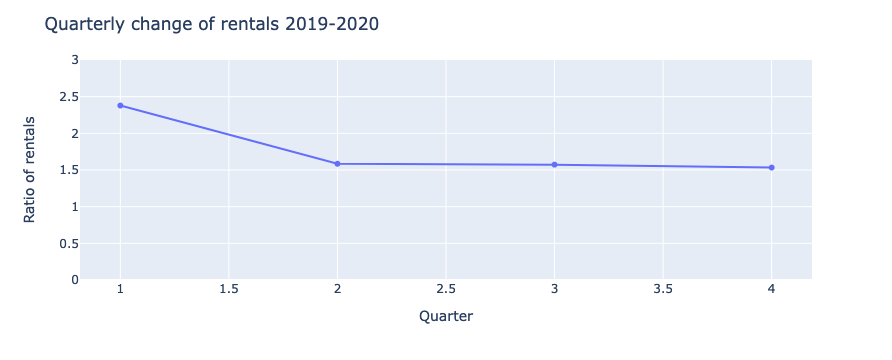

In [19]:
# To be safe: Preprocessing again
df_quarter = pd.read_parquet("escooter_history.parquet")
df_quarter["quarter"]=df_quarter["datetime"].dt.quarter
df_quarter["year"]=df_quarter["datetime"].dt.year

df_quarter_2019 = df_quarter[df_quarter["year"]==2019]

# For each year: Group by quarter
df_quarter_2019_g = df_quarter_2019.groupby("quarter",as_index=False).count()
df_quarter_2019_g = df_quarter_2019_g[["quarter","datetime"]].rename(columns={"datetime":"count_2019"})
df_quarter_2019_g

df_quarter_2020 = df_quarter[df_quarter["year"]==2020]
df_quarter_2020_g = df_quarter_2020.groupby("quarter",as_index=False).count()
df_quarter_2020_g = df_quarter_2020_g[["quarter","datetime"]].rename(columns={"datetime":"count_2020"})
df_quarter_2020_g

# Merge two dataframes on quarter
df_quarter_merged = pd.merge(df_quarter_2020_g,df_quarter_2019_g,how="inner",on="quarter")

# Calculate difference between two counts
# Result: Ratio from quarter 2020 to quarter 2019
df_quarter_merged["ratio"] = df_quarter_merged.count_2020 / df_quarter_merged.count_2019

# Show ratio 
fig_rat_q = px.line(df_quarter_merged,x="quarter",y="ratio",markers=True)
fig_rat_q.update_layout(title="Quarterly change of rentals 2019-2020",yaxis_range=[0,3], xaxis_title="Quarter", yaxis_title="Ratio of rentals")

# Interpretation: General success in 2020 as we've managed to increase our rentals even in comparison to the same quarter of the last year

## Relative development between same months (ratio between 2020Q1 to 2019Q1 etc.)

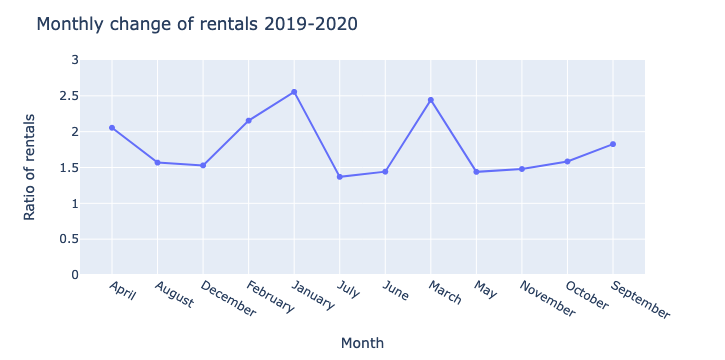

In [21]:
df_2019_grouped = df_2019.groupby("month_w",as_index=False).count()
df_2019_grouped = df_2019_grouped[["month_w","datetime"]]
df_2019_grouped = df_2019_grouped.rename(columns={"datetime":"count_2019"})

df_2020_grouped = df_2020.groupby("month_w", as_index=False).count()
df_2020_grouped = df_2020_grouped[["month_w","datetime"]]
df_2020_grouped = df_2020_grouped.rename(columns={"datetime":"count_2020"})

df_merged_y = pd.merge(df_2020_grouped,df_2019_grouped, how="inner", on="month_w")
df_merged_y["ratio"] = df_merged_y["count_2020"] / df_merged_y["count_2019"]

fig = px.line(df_merged_y, x="month_w", y="ratio", markers=True)
fig.update_layout(title="Monthly change of rentals 2019-2020",yaxis_range=[0,3], xaxis_title="Month", yaxis_title="Ratio of rentals")


## Erklärung, dass 2019 der stärkste prozentuale Anstieg an Ausleihen 2019 im Mai war und 2020 im März

In [78]:
df_w = df.groupby(["year","month"])[["weather","atemp"]].agg(pd.Series.mode)
df_w

# Häufigste gefühlte Temperatur war im Mai 2019 deutlich stärker als in den vorherigen Monaten und sieht nach Sommeranfang aus.
# 2020 gab es diesen Sommerbeginn bereits im März mit der gleichen häufigsten gefühlten Temperatur 

weather   atemp
year month                           
2019 1      clear, few clouds  11.365
     2      clear, few clouds  15.150
     3      clear, few clouds  15.150
     4      clear, few clouds  22.725
     5      clear, few clouds  31.060
     6      clear, few clouds  32.575
     7      clear, few clouds  34.850
     8      clear, few clouds  33.335
     9      clear, few clouds  27.275
     10     clear, few clouds  31.060
     11     clear, few clouds  22.725
     12     clear, few clouds  15.150
2020 1      clear, few clouds  11.365
     2      clear, few clouds  16.665
     3      clear, few clouds  31.060
     4      clear, few clouds  31.060
     5      clear, few clouds  31.060
     6      clear, few clouds  31.060
     7      clear, few clouds  34.850
     8      clear, few clouds  33.335
     9      clear, few clouds  31.060
     10     clear, few clouds  31.060
     11     clear, few clouds  16.665
     12     clear, few clouds  19.695

In [79]:
df_wt = df.groupby(["year","month"])[["weather","temp"]].agg(pd.Series.mode)
df_wt

# Auch richtige Temperatur bestätigt die oben genannte These 

weather   temp
year month                          
2019 1      clear, few clouds   8.20
     2      clear, few clouds  13.94
     3      clear, few clouds  13.94
     4      clear, few clouds  18.86
     5      clear, few clouds  24.60
     6      clear, few clouds  30.34
     7      clear, few clouds  32.80
     8      clear, few clouds  28.70
     9      clear, few clouds  27.06
     10     clear, few clouds  22.96
     11     clear, few clouds  18.86
     12     clear, few clouds  14.76
2020 1      clear, few clouds   8.20
     2      clear, few clouds  12.30
     3      clear, few clouds  24.60
     4      clear, few clouds  20.50
     5      clear, few clouds  26.24
     6      clear, few clouds  26.24
     7      clear, few clouds  32.80
     8      clear, few clouds  31.16
     9      clear, few clouds  27.06
     10     clear, few clouds  22.96
     11     clear, few clouds  14.76
     12     clear, few clouds  13.12

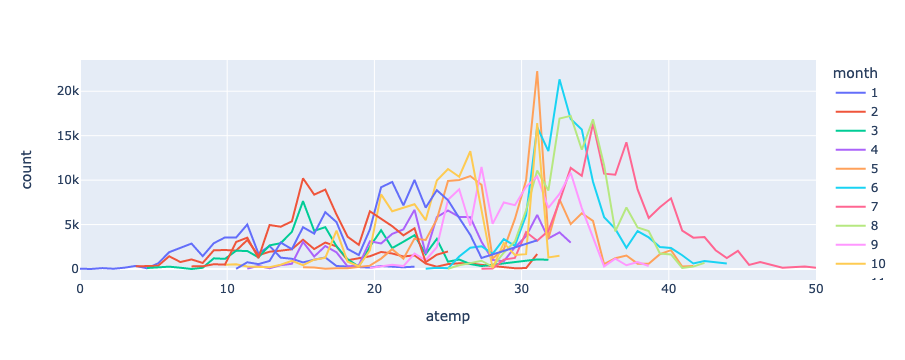

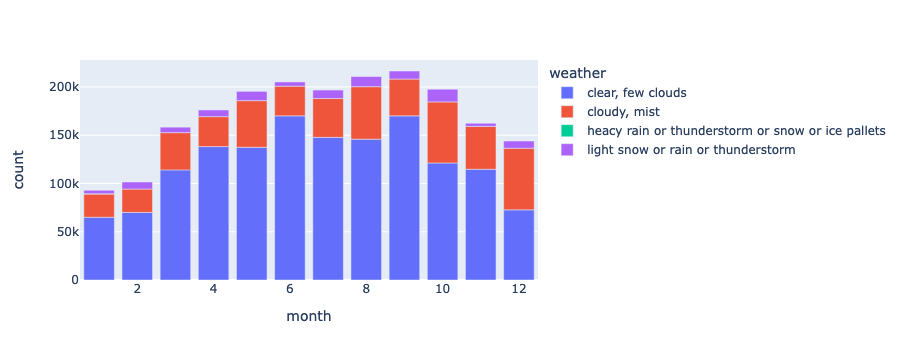

weather,"clear, few clouds","cloudy, mist",heacy rain or thunderstorm or snow or ice pallets,light snow or rain or thunderstorm
month,,,,
1,0.250000,0.250000,0.250000,0.250000
2,0.333333,0.333333,0.000000,0.333333
3,0.333333,0.333333,0.000000,0.333333
4,0.333333,0.333333,0.000000,0.333333
5,0.333333,0.333333,0.000000,0.333333
6,0.333333,0.333333,0.000000,0.333333
7,0.333333,0.333333,0.000000,0.333333
8,0.333333,0.333333,0.000000,0.333333
9,0.333333,0.333333,0.000000,0.333333


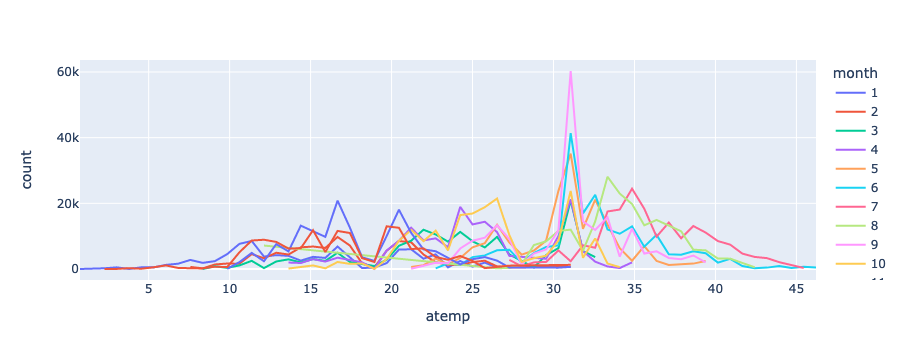